In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import geonamescache
from geopy.geocoders import Nominatim
from pygeocoder import Geocoder

In [152]:
%matplotlib inline

In [2]:
test_df = pd.read_csv('~/grive/InsightDataScience/Pricing_Test/test_results.csv')
print len(test_df)
test_df.head()

316800


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [3]:
'''# delete the wrong timestamp samples where min and sec are not in 0~59
test_df['min'] = test_df['timestamp'].apply(lambda x: int(x[14:16]))
test_df['sec'] = test_df['timestamp'].apply(lambda x: int(x[17:19]))
test_df=test_df.drop(test_df.index[test_df['min'] > 59])
test_df=test_df.drop(test_df.index[test_df['sec'] > 59])'''
# ignore the wrong min and seconds.
test_df['time_date'] = test_df['timestamp'].apply(lambda x: (x[:10]))
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,time_date
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24


In [4]:
# find the duration of this experiment
days = max(pd.to_datetime(test_df['time_date']))-min(pd.to_datetime(test_df['time_date']))
print days

90 days 00:00:00


In [5]:
user_df = pd.read_csv('~/grive/InsightDataScience/Pricing_Test/user_table.csv')
print len(user_df)
user_df.head()

275616


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [6]:
df = test_df.merge(user_df,left_on='user_id',right_on='user_id',how='left')
print len(df)
df.head()

316800


,user_id,timestamp,source,device,operative_system,test,price,converted,time_date,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,Fishers,USA,39.95,-86.02


In [7]:
# Get the same information for the joined table for which customers information is available.
print 'The total user number is %d. The number of price $39 and $59 are %d %d, respectively.' % (len(df), len(df.index[df['price']==39]), len(df.index[df['price']==59]))
print 'The percentage of B group to A group in this AB testing is %.2f and %.2f percent.' % (float(len(df.index[df['price']==39]))/len(df)*100, float(len(df.index[df['price']==59]))/len(df)*100)
print 'The number of users converted is %d, which is %.2f percent.' %(len(df.index[df['converted']==1]), float(len(df.index[df['converted']==1]))/len(df)*100)

The total user number is 316800. The number of price $39 and $59 are 202672 114128, respectively.
The percentage of B group to A group in this AB testing is 63.97 and 36.03 percent.
The number of users converted is 5808, which is 1.83 percent.


In [8]:
# know how many useres per operative_system 
#df.groupby('operative_system').agg({'test':{'num_os':len}})
df.groupby('operative_system').apply(lambda x: float(len(x))/len(df))
df.groupby('source').apply(lambda x: float(len(x))/len(df))

source
ads-bing           0.072200
ads-google         0.187434
ads-yahoo          0.023936
ads_facebook       0.168548
ads_other          0.094306
direct_traffic     0.190521
friend_referral    0.065325
seo-bing           0.006796
seo-google         0.073153
seo-other          0.029230
seo-yahoo          0.021616
seo_facebook       0.066935
dtype: float64

In [29]:
df['lat'] = df['lat'].apply(lambda x: format(x,'.6f'))
df['long'] = df['long'].apply(lambda x: format(x,'.6f'))
df['lat_lon'] = list(zip(df["lat"],df["long"]))
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,time_date,city,country,lat,long,lat_lon
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,Buffalo,USA,42.890000,-78.860000,"(42.890000, -78.860000)"
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,Lakeville,USA,44.680000,-93.240000,"(44.680000, -93.240000)"
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,Parma,USA,41.380000,-81.730000,"(41.380000, -81.730000)"
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,Fayetteville,USA,35.070000,-78.900000,"(35.070000, -78.900000)"
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,Fishers,USA,39.950000,-86.020000,"(39.950000, -86.020000)"


In [91]:
print np.isnan(df['city'][6]), pd.isnull(df['city'][5])
index = df.index[pd.isnull(df['city'])]
len(index)
index[:10]

True False


Int64Index([6, 12, 21, 38, 50, 63, 73, 75, 82, 88], dtype='int64')

In [132]:
df_cus_info = df.drop(index,axis=0)
df_cus_info = df_cus_info.reset_index(drop=True)
#df_cus_info.set_index([range(len(df_cus_info))])
df_cus_info[:10]
 # same as user table length, indicating there are no multiple clicks for the same user. should use inner join

,user_id,timestamp,source,device,operative_system,test,price,converted,time_date,city,country,lat,long,lat_lon
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,Buffalo,USA,42.890000,-78.860000,"(42.890000, -78.860000)"
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,Lakeville,USA,44.680000,-93.240000,"(44.680000, -93.240000)"
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,Parma,USA,41.380000,-81.730000,"(41.380000, -81.730000)"
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,Fayetteville,USA,35.070000,-78.900000,"(35.070000, -78.900000)"
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,Fishers,USA,39.950000,-86.020000,"(39.950000, -86.020000)"
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,2015-04-13,New York,USA,40.670000,-73.940000,"(40.670000, -73.940000)"
6,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,2015-03-15,East Orange,USA,40.770000,-74.210000,"(40.770000, -74.210000)"
7,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,2015-03-28,Dayton,USA,39.780000,-84.200000,"(39.780000, -84.200000)"
8,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,2015-04-24,Richmond,USA,37.530000,-77.470000,"(37.530000, -77.470000)"
9,590182,2015-04-17 13:30:04,ads-google,web,windows,0,39,0,2015-04-17,Bloomfield Township,USA,42.580000,-83.270000,"(42.580000, -83.270000)"


In [137]:
loc = Nominatim()
location = loc.reverse(df_cus_info['lat_lon'][0])
print location.raw['address']['state']
states=[]
n=10
for i in range(n):
    states.append(loc.reverse(df_cus_info['lat_lon'][i]).raw['address']['state']) #GeocoderQueryError: HTTP Error 400: Bad Request
print states,i
# timeout, service not available
#df_cus_info['state'] = df_cus_info['lat_lon'].apply(lambda x: loc.reverse(x).raw['address']['state'])
# The following code returns error with no results for some coordinates, can't apply across column
#df['state'] = df['lat_lon'].apply(lambda x: Geocoder.reverse_geocode(float(x[0]),float(x[1])).administrative_area_level_1)
#df_cus_info.head()

New York
[u'New York', u'Minnesota', u'Ohio', u'North Carolina', u'Indiana', u'New York', u'New Jersey', u'Ohio', u'Virginia', u'Michigan'] 9


In [134]:
#from city_to_state import city_to_state_dict
#df_cus_info['state'] = df_cus_info['city'].apply(lambda x: city_to_state_dict[x])
#df_cus_info.head()

KeyError: 'Bloomfield Township'

In [207]:
df_A = df[df['price']==39]
df_B = df[df['price']==59]
conv_39=float(len(df_A.index[df_A['converted']==1]))/len(df_A)
conv_59=float(len(df_B.index[df_B['converted']==1]))/len(df_B)
print 'The number of users converted in A test group is %d, which is %.2f percent.' %(len(df_A.index[df_A['converted']==1]), float(len(df_A.index[df_A['converted']==1]))/len(df_A)*100)
print 'The number of users converted in B test group is %d, which is %.2f percent.' %(len(df_B.index[df_B['converted']==1]), float(len(df_B.index[df_B['converted']==1]))/len(df_B)*100)
rev_delta = len(df_B.index[df_B['converted']==1])*59-(float(len(df_A.index[df_A['converted']==1]))/len(df_A)*len(df_B))*39
rev_percent = rev_delta/((float(len(df_A.index[df_A['converted']==1])))/len(df_A)*len(df_B)*39)
print 'The increased revenue by increasing price from 39 to 59 dollars is %.2f dollars and %.2f percent.' %  (rev_delta, rev_percent*100)

The number of users converted in A test group is 4031, which is 1.99 percent.
The number of users converted in B test group is 1777, which is 1.56 percent.
The increased revenue by increasing price from 39 to 59 dollars is 16315.98 dollars and 18.43 percent.


In [212]:
# The equation to calculate optimal price is the gradient of X*(p*(59-X)+q*(X-39))/20, p is the conversion rate for $39
# and q is the conversion rate for $59. X = (59p-39q)/2(q-p)
optimal_price = (59*conv_39-39*conv_59)/2/(conv_39-conv_59)
print 'The optimal price to generate the optimal revenue is %.2f dollars.' % optimal_price

The optimal price to generate the optimal revenue is 65.55 dollars.


In [185]:
df_source = df.groupby('source').agg({'test':[sum, len, lambda x: x.sum()/float(len(x))], 'converted':[sum, lambda x: x.sum()/float(len(x))]})
df_source.head()

test                  converted          
                sum    len  <lambda>       sum  <lambda>
source                                                  
ads-bing       8264  22873  0.361299       274  0.011979
ads-google    21515  59379  0.362333      1276  0.021489
ads-yahoo      2765   7583  0.364631       112  0.014770
ads_facebook  19297  53396  0.361394      1132  0.021200
ads_other     10592  29876  0.354532       429  0.014359

In [173]:
df_source_test = df.groupby(['source','test']).agg({'converted':[sum,len, lambda x: x.sum()/float(len(x))]})
df_source_test = pd.DataFrame(df_source_test.to_records())
df_source_test.columns = ['source','test','converted','total_num','conv_rate']
df_source_test.head()

,source,test,converted,total_num,conv_rate
0,ads-bing,0,195,14609,0.013348
1,ads-bing,1,79,8264,0.009560
2,ads-google,0,854,37864,0.022554
3,ads-google,1,422,21515,0.019614
4,ads-yahoo,0,81,4818,0.016812


In [177]:
rev_increase_price = []
rev_normal_price = []
rev_inc_norm = []
for i in range(len(df_source_test)):
    if df_source_test['test'][i] == 1:
        rev_increase_price.append(59*df_source_test['conv_rate'][i])
    else:
        rev_normal_price.append(39*df_source_test['conv_rate'][i])
rev_inc_norm = [a/b for a,b in zip(rev_increase_price,rev_normal_price)]

[1.083452971722761, 1.3156098788829291, 1.0088712350315725, 1.0765868651544583, 1.2241201229116638, 1.1273106800803807, 1.2134884552007421, 0.67762906609060469, 1.3776241721720361, 1.077661262683137, 0.81245749003826884, 1.1773470767165366]


In [186]:
df_source['rev_inc_norm'] = rev_inc_norm
df_source = pd.DataFrame(df_source.to_records())
df_source.columns = ['source','test_inc','total','test_ratio','conv','conv_ratio','rev_inc_norm']
df_source.head()

,source,test_inc,total,test_ratio,conv,conv_ratio,rev_inc_norm
0,ads-bing,8264,22873,0.361299,274,0.011979,1.083453
1,ads-google,21515,59379,0.362333,1276,0.021489,1.315610
2,ads-yahoo,2765,7583,0.364631,112,0.014770,1.008871
3,ads_facebook,19297,53396,0.361394,1132,0.021200,1.076587
4,ads_other,10592,29876,0.354532,429,0.014359,1.224120


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

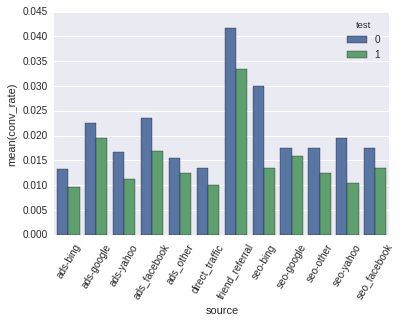

In [156]:
ax = sns.barplot(x='source',y='conv_rate', hue = 'test', data=df_source_test)
plt.xticks(rotation = 60)

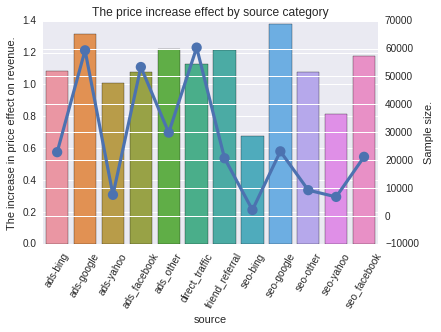

In [280]:
# point line shows the overall convertion ratio for each source
# barplot shows the increase in price effect on revenue for each source. number greater than 1 indicates a positive effect.
ax1 = sns.barplot(x='source',y='rev_inc_norm', data=df_source)
plt.xticks(rotation = 60)
ax1.set_ylabel('The increase in price effect on revenue.')
ax2 = plt.twinx(ax1)
sns.pointplot(x='source',y='total',data=df_source,ax=ax2)
ax2.set_ylabel('Sample size.')
plt.title('The price increase effect by source category')

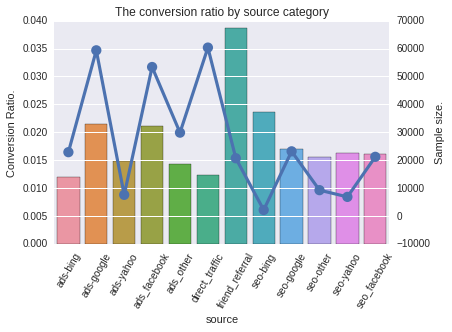

In [281]:
ax1 = sns.barplot(x='source',y='conv_ratio', data=df_source)
plt.xticks(rotation = 60)
ax1.set_ylabel('Conversion Ratio.')
ax2 = plt.twinx(ax1)
sns.pointplot(x='source',y='total',data=df_source,ax=ax2)
ax2.set_ylabel('Sample size.')
plt.title('The conversion ratio by source category')

In [202]:
df_os = df.groupby('operative_system').agg({'test':[sum, len, lambda x: x.sum()/float(len(x))], 'converted':[sum, lambda x: x.sum()/float(len(x))]})
df_os

test                   converted          
                    sum     len  <lambda>       sum  <lambda>
operative_system                                             
android           26725   74935  0.356642      1119  0.014933
iOS               33610   95465  0.352066      2131  0.022322
linux              1928    4135  0.466264        34  0.008222
mac                8719   25085  0.347578       602  0.023998
other              5706   16204  0.352135       210  0.012960
windows           37385  100976  0.370236      1712  0.016955

In [200]:
df_os_test = df.groupby(['operative_system','test']).agg({'converted':[sum,len, lambda x: x.sum()/float(len(x))]})
df_os_test = pd.DataFrame(df_os_test.to_records())
df_os_test.columns = ['os','test','converted','total_num','conv_rate']
df_os_test.head()

,os,test,converted,total_num,conv_rate
0,android,0,789,48210,0.016366
1,android,1,330,26725,0.012348
2,iOS,0,1459,61855,0.023587
3,iOS,1,672,33610,0.019994
4,linux,0,34,2207,0.015406


In [201]:
rev_increase_price = []
rev_normal_price = []
rev_inc_norm = []
for i in range(len(df_os_test)):
    if df_os_test['test'][i] == 1:
        rev_increase_price.append(59*df_os_test['conv_rate'][i])
    else:
        rev_normal_price.append(39*df_os_test['conv_rate'][i])
rev_inc_norm = [a/b for a,b in zip(rev_increase_price,rev_normal_price)]

In [203]:
df_os['rev_inc_norm'] = rev_inc_norm
df_os = pd.DataFrame(df_os.to_records())
df_os.columns = ['source','test_inc','total','test_ratio','conv','conv_ratio','rev_inc_norm']
df_os.head()

,source,test_inc,total,test_ratio,conv,conv_ratio,rev_inc_norm
0,android,26725,74935,0.356642,1119,0.014933,1.141415
1,iOS,33610,95465,0.352066,2131,0.022322,1.282353
2,linux,1928,4135,0.466264,34,0.008222,0.000000
3,mac,8719,25085,0.347578,602,0.023998,1.259792
4,other,5706,16204,0.352135,210,0.012960,1.192849


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

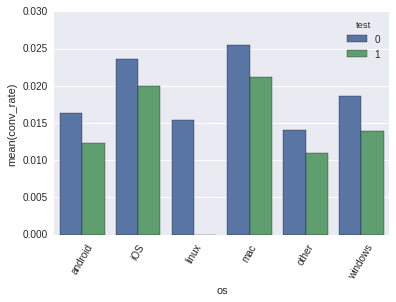

In [158]:
ax = sns.barplot(x='os',y='conv_rate', hue = 'test', data=df_os_test)
plt.xticks(rotation = 60)

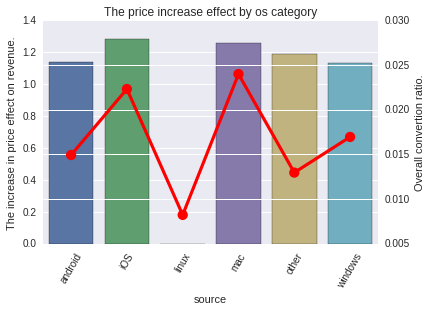

In [206]:
# point line shows the overall convertion ratio for each source
# barplot shows the increase in price effect on revenue for each source. number greater than 1 indicates a positive effect.
ax1 = sns.barplot(x='source',y='rev_inc_norm', data=df_os)
plt.xticks(rotation = 60)
ax1.set_ylabel('The increase in price effect on revenue.')
ax2 = plt.twinx(ax1)
sns.pointplot(x='source',y='conv_ratio',data=df_os,ax=ax2,color= 'r')
ax2.set_ylabel('Overall convertion ratio.')
plt.title('The price increase effect by os category')

In [161]:
df_city_test = df.groupby(['city','test']).agg({'converted':[sum,len, lambda x: x.sum()/float(len(x))]})
print len(df_city_test)
df_city_test.head()

1832


converted               
                   sum  len  <lambda>
city    test                         
Abilene 0            7  281  0.024911
        1            1  150  0.006667
Akron   0            6  224  0.026786
        1            1  135  0.007407
Alameda 0            2  105  0.019048

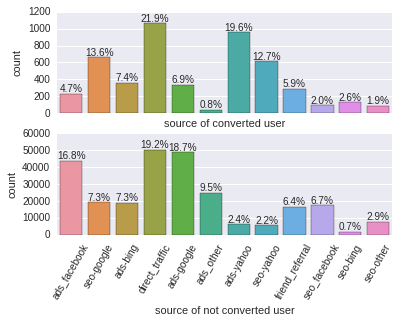

In [134]:
# the code below this cell is the early stage try and should be ignored.
plt.subplot(2, 1, 1)
ncount = len(df_converted)
ax1 = sns.countplot(x='source',data = df_converted)
for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') 
plt.xticks([])
plt.xlabel('source of converted user')
plt.subplot(2, 1, 2)
ncount = len(df_not_converted)
ax2 = sns.countplot(x='source',data = df_not_converted)
for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') 
plt.xticks(rotation = 60)
plt.xlabel('source of not converted user')
plt.show()

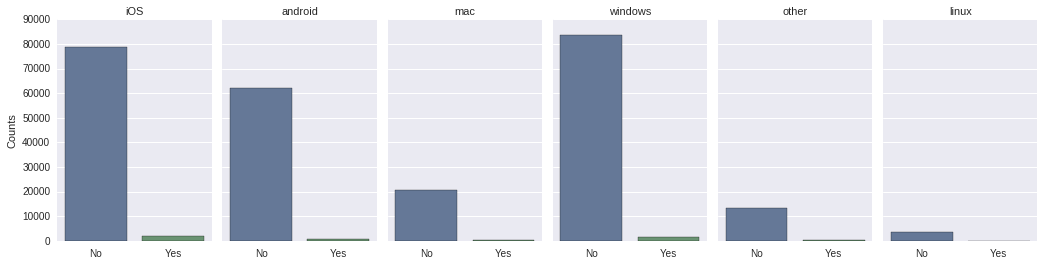

In [150]:
g = sns.factorplot("converted", col="operative_system",
...                    data=df, saturation=.5,
...                    kind="count", ci=None, aspect=.6)

(g.set_axis_labels("", "Counts")
...   .set_xticklabels(["No", "Yes"])
...   .set_titles("{col_name}")
...   .despine(left=True))

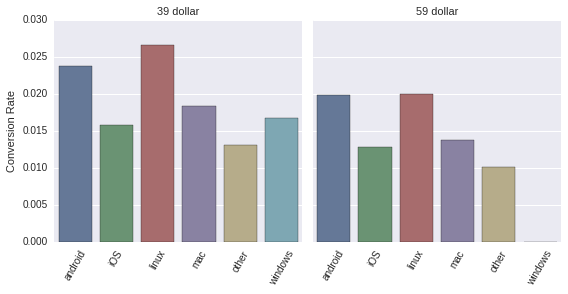

In [138]:
g = sns.factorplot(x="operative_system",y="converted", col="price",
...                    data=df, saturation=.5,
...                    kind="bar", ci=None)

(g.set_axis_labels("", "Conversion Rate")
...   .set_xticklabels(["android", "iOS","linux","mac","other","windows"],rotation = 60)
...   .set_titles("{col_name} dollar")
...   .despine(left=True))

In [140]:
num_feats=['source','operative_system','price','city']
X = df[num_feats]
y = df['converted']
X.head()

,source,operative_system,price,city
0,ads_facebook,iOS,39,Buffalo
1,seo-google,android,39,Lakeville
2,ads-bing,android,39,Parma
3,direct_traffic,iOS,59,Fayetteville
4,ads_facebook,mac,39,Fishers


In [229]:
n=30
faster_df = df.drop(df.index[pd.to_datetime(df['time_date'])> (min(pd.to_datetime(df['time_date']))+timedelta(days=n))])
print 'The sample number within %d days of experiment is %d and %.2f percent of the total samples.' % (n, len(faster_df), float(len(faster_df))/len(df)*100)
faster_df.head()

The sample number within 30 days of experiment is 102178 and 32.25 percent of the total samples.


,user_id,timestamp,source,device,operative_system,test,price,converted,time_date,city,country,lat,long,lat_lon
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0,2015-03-04,NaN,NaN,nan,nan,"(nan, nan)"
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,2015-03-15,East Orange,USA,40.770000,-74.210000,"(40.770000, -74.210000)"
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,2015-03-28,Dayton,USA,39.780000,-84.200000,"(39.780000, -84.200000)"
13,460593,2015-03-21 09:43:51,friend_referral,mobile,iOS,0,39,1,2015-03-21,Hampton,USA,37.050000,-76.290000,"(37.050000, -76.290000)"
15,552048,2015-03-22 08:58:32,ads-bing,web,windows,1,59,0,2015-03-22,Culver City,USA,34.010000,-118.400000,"(34.010000, -118.400000)"


In [241]:
faster_df = faster_df.groupby(['test']).agg({'converted':[len,lambda x: x.sum()/float(len(x))]})
faster_df = pd.DataFrame(faster_df.to_records())
faster_df.columns = ['index','test','total','conv_rate']
print 'The number of users converted in 0 test group is %d, which is %.2f percent.' %(faster_df['total'][0],faster_df['conv_rate'][0]*100)
print 'The number of users converted in 1 test group is %d, which is %.2f percent.' %(faster_df['total'][1],faster_df['conv_rate'][1]*100)
rev_inc_norm = faster_df['conv_rate'][1]*59/faster_df['conv_rate'][0]/39
print 'The increased revenue ratio by increasing price from 39 to 59 dollars is %.2f times after %d days of experiment.' %  (rev_inc_norm,n)
faster_df.head()

The number of users converted in 0 test group is 65273, which is 1.97 percent.
The number of users converted in 1 test group is 36905, which is 1.61 percent.
The increased revenue ratio by increasing price from 39 to 59 dollars is 1.24 times after 30 days of experiment.


,index,test,total,conv_rate
0,0,0,65273,0.019656
1,1,1,36905,0.016122


In [249]:
rev_del = []
rev_perc = []
days = []
start_day = min(pd.to_datetime(df['time_date']))
for i in np.arange(4,90,7):
    new_df = df.drop(df.index[pd.to_datetime(df['time_date'])> (start_day+timedelta(days=i))])
    new_df_A = new_df[new_df['price']==39]
    new_df_B = new_df[new_df['price']==59]
    delta = len(new_df_B.index[new_df_B['converted']==1])*59-(float(len(new_df_A.index[new_df_A['converted']==1]))/len(new_df_A)*len(new_df_B))*39
    rev_del.append(round(delta,2))
    rev_perc.append(delta/((float(len(new_df_A.index[new_df_A['converted']==1]))/len(new_df_A)*len(new_df_B))*39))
    days.append(i)

In [250]:
time_exp = pd.DataFrame()
time_exp['days'] = days
time_exp['rev_inc'] = rev_del
time_exp['rev_inc_perc'] = rev_perc
time_exp.head()

,days,rev_inc,rev_inc_perc
0,4,790.87,0.179697
1,11,2753.71,0.253208
2,18,4208.69,0.243737
3,25,5902.02,0.243412
4,32,6791.89,0.216433


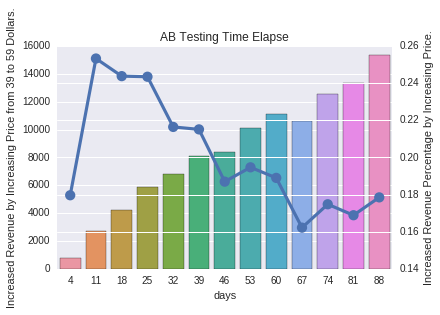

In [251]:
ax1 = sns.barplot(x='days',y = 'rev_inc', data = time_exp)
ax1.set_ylabel('Increased Revenue by Increasing Price from 39 to 59 Dollars.')
ax2 = plt.twinx(ax1)
sns.pointplot(x='days', y = 'rev_inc_perc',data = time_exp, ax=ax2)
ax2.set_ylabel('Increased Revenue Percentage by Increasing Price.')
plt.title('AB Testing Time Elapse')

In [258]:
rev_inc_norm = []
days = []
start_day = min(pd.to_datetime(df['time_date']))
j=0
for i in np.arange(3,90,7):
    new_df = df.drop(df.index[pd.to_datetime(df['time_date']) > (start_day+timedelta(days=i))])
    new_df = new_df.drop(new_df.index[pd.to_datetime(new_df['time_date'])< (start_day+timedelta(days=j))])
    new_df = new_df.groupby(['test']).agg({'converted':lambda x: x.sum()/float(len(x))})
    new_df = pd.DataFrame(new_df.to_records())
    new_df.columns = ['test','conv_rate']
    rev_inc_norm.append(new_df['conv_rate'][1]*59/new_df['conv_rate'][0]/39)
    days.append(i)
    j = i


In [259]:
time_exp = pd.DataFrame()
time_exp['days'] = days
time_exp['rev_inc_norm'] = rev_inc_norm
time_exp.head()

,days,rev_inc_norm
0,3,1.052706
1,10,1.320781
2,17,1.227299
3,24,1.316839
4,31,1.182735


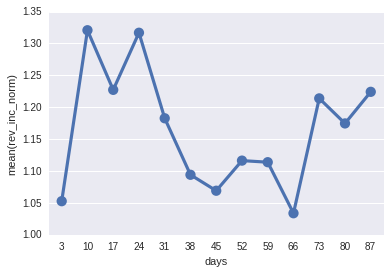

In [261]:
sns.pointplot(x='days',y='rev_inc_norm', data = time_exp)

In [278]:
std = []
mean = []
week = []
lower = []
for i in range(1,len(time_exp)):
    std.append(np.std(time_exp['rev_inc_norm'][:i])/(i**0.5))
    mean.append(np.mean(time_exp['rev_inc_norm'][:i]))
    week.append(i)
    lower.append(mean[i-1]-2.56*std[i-1]) # 99% confidence interval
time_eff = pd.DataFrame({'week':week,'mean':mean,'std':std,'lower_interval':lower})
time_eff
# Starting from week 3, the stats are significant to indicate the price increase do result in a increased revenue.

,lower_interval,mean,std,week
0,1.052706,1.052706,0.000000,1
1,0.944109,1.186743,0.094779,2
2,1.036056,1.200262,0.064143,3
3,1.090331,1.229406,0.054326,4
4,1.106778,1.220072,0.044256,5
5,1.092682,1.199079,0.041561,6
6,1.079251,1.180512,0.039555,7
7,1.081827,1.172489,0.035415,8
8,1.083864,1.165973,0.032074,9
9,1.072188,1.152756,0.031472,10
